# Telco Customer Churn Analysis
---

1. Buat model Machine Learning Menggunakan data Telco Customer Churn
2. Target: Churn (yes: Customers who left within the last month,)
3. Binary Classification
4. model.predict() -> Accuracy

    Data Source : https://www.kaggle.com/datasets/blastchar/telco-customer-churn

1. Eexploratory Data Analysis -> Find Problen in dataset
2. Preparation and feature engineering 
3. Model Selection
4. Hyperparameter Tunning
5. Find Best Model

In [ ]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split, cross_val_score, KFold, RandomizedSearchCV
from sklearn.feature_selection import SelectKBest, chi2

from sklearn.utils.class_weight import compute_class_weight

from sklearn.metrics import classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost.sklearn import XGBClassifier

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as Pipeline_im

import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
churn = pd.read_csv('/content/Telco-Customer-Churn.csv')

churn.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


### 1. Exploratory Data Analysis -> Find Problem in dataset

##### Check Typo & data type

In [ ]:
churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [ ]:
unique_list = [churn[column].unique() for column in churn.select_dtypes('O').columns]
nunique_list = [churn[column].nunique() for column in churn.select_dtypes('O').columns]

unique_df = pd.DataFrame({'Column': churn.select_dtypes('O').columns, 'N-Unique': nunique_list, 'Unique':unique_list})
unique_df

,Column,N-Unique,Unique
0,customerID,7043,"[7590-VHVEG, 5575-GNVDE, 3668-QPYBK, 7795-CFOC..."
1,gender,2,"[Female, Male]"
2,Partner,2,"[Yes, No]"
3,Dependents,2,"[No, Yes]"
4,PhoneService,2,"[No, Yes]"
5,MultipleLines,3,"[No phone service, No, Yes]"
6,InternetService,3,"[DSL, Fiber optic, No]"
7,OnlineSecurity,3,"[No, Yes, No internet service]"
8,OnlineBackup,3,"[Yes, No, No internet service]"
9,DeviceProtection,3,"[No, Yes, No internet service]"


- Data kategori berisi data nominal dan memiliki kategori yang tidak brgitu banyak -> OneHot Encoding
- Total Charges -> Float (bukan object)
- Total Charges -> Object : Di dalam kolom TotalCharges terdapat value yang bukan angka

In [ ]:
churn['TotalCharges'] = pd.to_numeric(churn['TotalCharges'], errors='coerce')

##### Check Missing Value

In [ ]:
churn.isnull().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

Terdapat missing value

In [ ]:
churn.dropna(inplace=True)

##### Check Imbalance

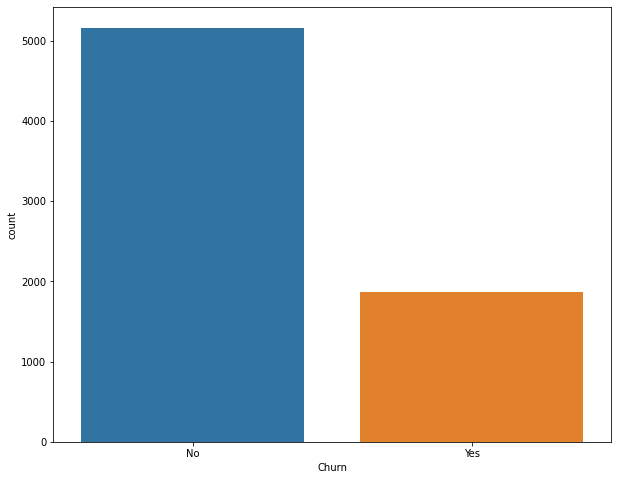

In [ ]:
plt.figure(figsize=(10, 8))
sns.countplot(x=churn['Churn'])
plt.show()

Terjadi data imbalance:
- Resampling (Under/Over) -> Smote
- Algorithm -> Class_weight = balance

##### Check descriptive analytics

In [ ]:
churn.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7032.000000,7032.000000,7032.000000,7032.000000
mean,0.162400,32.421786,64.798208,2283.300441
std,0.368844,24.545260,30.085974,2266.771362
min,0.000000,1.000000,18.250000,18.800000
25%,0.000000,9.000000,35.587500,401.450000
50%,0.000000,29.000000,70.350000,1397.475000
75%,0.000000,55.000000,89.862500,3794.737500
max,1.000000,72.000000,118.750000,8684.800000


##### Check Distributions (variable Numeric)

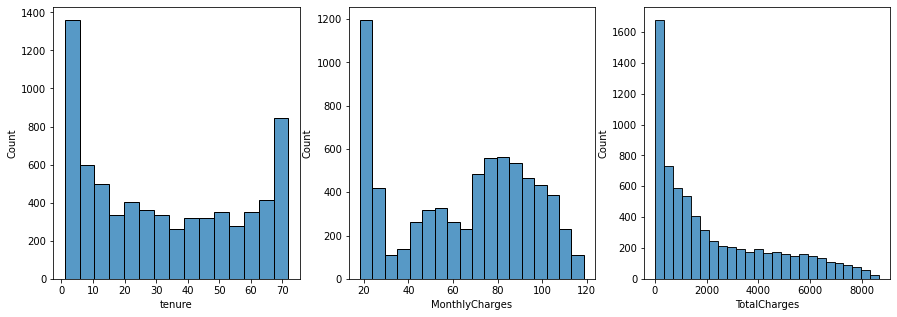

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

sns.histplot(churn['tenure'], ax=axes[0])
sns.histplot(churn['MonthlyCharges'], ax=axes[1])
sns.histplot(churn['TotalCharges'], ax=axes[2])

plt.show()

##### Check Outlier

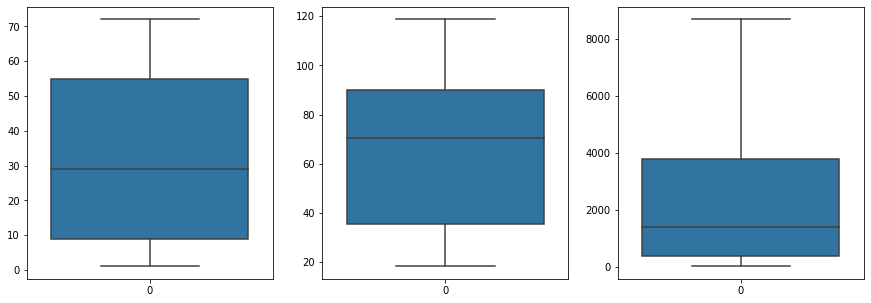

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

sns.boxplot(data = churn['tenure'], ax=axes[0])
sns.boxplot(data = churn['MonthlyCharges'], ax=axes[1])
sns.boxplot(data = churn['TotalCharges'], ax=axes[2])

plt.show()

### 2. Data Preparation and feature engineering

Untuk tahap validation dan evaluation kita bagi data menjadi 3: Data Train, Data Validation dan Data Test

##### Define features and target

In [ ]:
target = np.where(churn['Churn'] == "Yes", 1, 0) 
features = churn.drop(columns=['Churn', 'customerID'])

In [ ]:
target

array([0, 0, 1, ..., 0, 1, 0])

In [ ]:
features.shape

(7032, 19)

##### Splitting

In [ ]:
X_train_val, X_test, y_train_val, y_test = train_test_split(features, target, 
                                                            test_size=0.2,
                                                            random_state=42,
                                                            stratify=target)

print(X_train_val.shape)
print(y_train_val.shape)

(5625, 19)
(5625,)


In [ ]:
print(X_test.shape)
print(y_test.shape)

(1407, 19)
(1407,)


##### Feature Engineering

In [ ]:
X_train_val.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5625 entries, 1413 to 1505
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            5625 non-null   object 
 1   SeniorCitizen     5625 non-null   int64  
 2   Partner           5625 non-null   object 
 3   Dependents        5625 non-null   object 
 4   tenure            5625 non-null   int64  
 5   PhoneService      5625 non-null   object 
 6   MultipleLines     5625 non-null   object 
 7   InternetService   5625 non-null   object 
 8   OnlineSecurity    5625 non-null   object 
 9   OnlineBackup      5625 non-null   object 
 10  DeviceProtection  5625 non-null   object 
 11  TechSupport       5625 non-null   object 
 12  StreamingTV       5625 non-null   object 
 13  StreamingMovies   5625 non-null   object 
 14  Contract          5625 non-null   object 
 15  PaperlessBilling  5625 non-null   object 
 16  PaymentMethod     5625 non-null   objec

In [ ]:
cat_columns = X_train_val.select_dtypes('O').columns
cat_columns

Index(['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod'],
      dtype='object')

In [ ]:
# Preprocessing schema

ct = ColumnTransformer([('OneHotEncoder', OneHotEncoder(drop='first'), cat_columns),
                        ('MinMaxScaller', MinMaxScaler(), ['tenure', 'MonthlyCharges', 'TotalCharges'])], 
                       remainder='passthrough')

ct.fit(X_train_val)

ColumnTransformer(remainder='passthrough',
                  transformers=[('OneHotEncoder', OneHotEncoder(drop='first'),
                                 Index(['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod'],
      dtype='object')),
                                ('MinMaxScaller', MinMaxScaler(),
                                 ['tenure', 'MonthlyCharges', 'TotalCharges'])])

In [ ]:
X_train_val_pre = ct.transform(X_train_val)
X_train_val_pre

array([[1.        , 1.        , 1.        , ..., 0.759601  , 0.69927879,
        0.        ],
       [1.        , 0.        , 0.        , ..., 0.17306733, 0.11582045,
        0.        ],
       [0.        , 1.        , 0.        , ..., 0.71620948, 0.72453843,
        0.        ],
       ...,
       [0.        , 1.        , 1.        , ..., 0.74314214, 0.38777406,
        0.        ],
       [0.        , 1.        , 1.        , ..., 0.47381546, 0.07399608,
        0.        ],
       [1.        , 0.        , 0.        , ..., 0.56159601, 0.0064505 ,
        1.        ]])

In [ ]:
columns_name = list(ct.transformers_[0][1].get_feature_names_out()) + ['tenure', 'MonthlyCharges', 'TotalCharges', 'SeniorCitizen']

X_train_val_pre_df =  pd.DataFrame(X_train_val_pre, columns=columns_name)

In [ ]:
# Hasil Preview Preprocessing data (X_train_val)
X_train_val_pre_df.head()

,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,...,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,tenure,MonthlyCharges,TotalCharges,SeniorCitizen
0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.901408,0.759601,0.699279,0.0
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.352113,0.173067,0.115820,0.0
2,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.943662,0.716209,0.724538,0.0
3,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.028169,0.657357,0.024954,0.0
4,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.676056,0.221945,0.236782,0.0


##### Feature Selection


In [ ]:
# Preview X_train_val_pre setelah dilakukan proses feature selection

select = SelectKBest(chi2, k=10)

X_train_val_select = select.fit_transform(X_train_val_pre_df, y_train_val)

In [ ]:
# Before selection
X_train_val.shape

(5625, 19)

In [ ]:
# After Selection
X_train_val_select.shape

(5625, 12)

In [ ]:
feature_selection_df = pd.DataFrame({'Column': select.feature_names_in_, 'Score': select.scores_, 'P-Values':select.pvalues_})

In [ ]:
feature_selection_df.sort_values(by='Score', ascending=False)

,Column,Score,P-Values
21,Contract_Two year,388.655168,1.624240e-86
24,PaymentMethod_Electronic check,346.643724,2.280480e-77
6,InternetService_Fiber optic,295.005561,4.035723e-66
16,StreamingTV_No internet service,228.447173,1.300149e-51
7,InternetService_No,228.447173,1.300149e-51
8,OnlineSecurity_No internet service,228.447173,1.300149e-51
10,OnlineBackup_No internet service,228.447173,1.300149e-51
12,DeviceProtection_No internet service,228.447173,1.300149e-51
18,StreamingMovies_No internet service,228.447173,1.300149e-51
14,TechSupport_No internet service,228.447173,1.300149e-51


### 3. Build Model

##### Model Selection
- Adaboosting (tree)
- Random Forest
- XGBClassifier
- LogisticRegression
- KNN 

In [ ]:
# Base Estimator
tree = DecisionTreeClassifier(max_depth=5)

# Estimator
adaboost = AdaBoostClassifier(tree)
rf = RandomForestClassifier()
logreg = LogisticRegression()
xgb = XGBClassifier()
knn = KNeighborsClassifier()

In [ ]:
def train(model, X, y, score='f1', fold=5, ct=ct, select=SelectKBest(chi2)):
  
  pipe = Pipeline([('Preprocessing', ct),
                   ('FeatureSelection', select),
                   ('Clf', model)])
  
  cv = cross_val_score(pipe, X, y, cv=KFold(n_splits=fold, shuffle=True, random_state=42), scoring=score)
  cv_mean = cv.mean()

  return [model, cv, cv_mean]

In [ ]:
train(rf, X_train_val, y_train_val)

[RandomForestClassifier(),
 array([0.48618785, 0.4857685 , 0.51012146, 0.50367647, 0.52054795]),
 0.5012604439072454]

In [ ]:
train(rf, X_train_val, y_train_val)[2]

0.5012604439072454

In [ ]:
# Scoring -> f1

models = [('adaboost', adaboost), ('Random Forest', rf), ('Logistic Regression', logreg), ('XGBoosting', xgb), ('KNearestNeighbor', knn)]

result = [train(model[1], X_train_val, y_train_val) for model in models]
result_np = np.array(result)

result_df = pd.DataFrame({'Model':[model[0] for model in models], 'Cross-Validation Score':result_np[:, 1], 'Cross-Validation Mean Score':result_np[:, 2]})
result_df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


,Model,Cross-Validation Score,Cross-Validation Mean Score
0,adaboost,"[0.4861878453038674, 0.4857685009487666, 0.510...",0.50126
1,Random Forest,"[0.4861878453038674, 0.4857685009487666, 0.510...",0.50126
2,Logistic Regression,"[0.4861878453038674, 0.4857685009487666, 0.510...",0.50126
3,XGBoosting,"[0.4861878453038674, 0.4857685009487666, 0.510...",0.50126
4,KNearestNeighbor,"[0.17258883248730966, 0.5157232704402516, 0.16...",0.240503


In [ ]:
# Scoring -> accuracy

models = [('adaboost', adaboost), ('Random Forest', rf), ('Logistic Regression', logreg), ('XGBoosting', xgb), ('KNearestNeighbor', knn)]

result = [train(model[1], X_train_val, y_train_val, score='accuracy') for model in models]
result_np = np.array(result)

result_df = pd.DataFrame({'Model':[model[0] for model in models], 'Cross-Validation Score':result_np[:, 1], 'Cross-Validation Mean Score':result_np[:, 2]})
result_df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


,Model,Cross-Validation Score,Cross-Validation Mean Score
0,adaboost,"[0.752, 0.7591111111111111, 0.7848888888888889...",0.761422
1,Random Forest,"[0.752, 0.7591111111111111, 0.7848888888888889...",0.761422
2,Logistic Regression,"[0.752, 0.7591111111111111, 0.7848888888888889...",0.761422
3,XGBoosting,"[0.752, 0.7591111111111111, 0.7848888888888889...",0.761422
4,KNearestNeighbor,"[0.7102222222222222, 0.7262222222222222, 0.730...",0.714311


In [ ]:
# Scoring -> f1 -> Full Pakai semua features

models = [('adaboost', adaboost), ('Random Forest', rf), ('Logistic Regression', logreg), ('XGBoosting', xgb), ('KNearestNeighbor', knn)]

result = [train(model[1], X_train_val, y_train_val, select=SelectKBest(chi2, k=19)) for model in models]
result_np = np.array(result)

result_df = pd.DataFrame({'Model':[model[0] for model in models], 'Cross-Validation Score':result_np[:, 1], 'Cross-Validation Mean Score':result_np[:, 2]})
result_df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


,Model,Cross-Validation Score,Cross-Validation Mean Score
0,adaboost,"[0.5207296849087895, 0.5320197044334976, 0.505...",0.529985
1,Random Forest,"[0.5504273504273505, 0.5105633802816901, 0.554...",0.526143
2,Logistic Regression,"[0.6010733452593918, 0.5724770642201835, 0.582...",0.584234
3,XGBoosting,"[0.5989304812834224, 0.5568181818181819, 0.603...",0.583934
4,KNearestNeighbor,"[0.5182481751824817, 0.5166051660516605, 0.526...",0.512229


F1-score meningkat jika kita tidak memakai proses feature selection

Handing Imbalance (Algorithm)

In [ ]:
# Scoring -> f1 -> Full Pakai semua features

logreg_new = LogisticRegression(class_weight='balanced')
xgb_new = XGBClassifier()

models = [('Logistic Regression', logreg_new), ('XGBoosting', xgb_new)]

result = [train(model[1], X_train_val, y_train_val, select=SelectKBest(chi2, k=19)) for model in models]
result_np = np.array(result)

result_df = pd.DataFrame({'Model':[model[0] for model in models], 'Cross-Validation Score':result_np[:, 1], 'Cross-Validation Mean Score':result_np[:, 2]})
result_df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  if __name__ == '__main__':


,Model,Cross-Validation Score,Cross-Validation Mean Score
0,Logistic Regression,"[0.6161745827984596, 0.6063829787234042, 0.603...",0.624203
1,XGBoosting,"[0.5989304812834224, 0.5568181818181819, 0.603...",0.583934


##### Hyperparameter Tuning
- Logistic Regression: C, solver, max_iter
- XGboost: n_estimator, max_depth, learning_rate

In [ ]:
logreg_new = LogisticRegression(class_weight='balanced')
xgb_new = XGBClassifier()

In [ ]:
# Logistic Regression

pipe = Pipeline([('Preprocessing', ct),
                   ('Clf', logreg_new)])

hyperparameter_space = {
    'Clf__C': [10, 1, 0.1, 0.01, 0.001],
    'Clf__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'Clf__max_iter': [300, 200, 100, 50]
}

rs = RandomizedSearchCV(pipe,
                        n_iter=40,
                        param_distributions=hyperparameter_space,
                        scoring='f1',
                        cv=KFold(n_splits=5, shuffle=True, random_state=42),
                        random_state=42,
                        return_train_score=True,
                        verbose=4)

In [ ]:
rs.fit(X_train_val, y_train_val)

In [ ]:
print(rs.best_score_)
print(rs.best_params_)

0.6334509505810825
{'Clf__solver': 'liblinear', 'Clf__max_iter': 300, 'Clf__C': 1}


##### Model Benchmark

Before (with pipeline)

In [ ]:
logreg_before = LogisticRegression(class_weight='balanced')

pipe = Pipeline([('Preprocessing', ct),
                   ('Clf', logreg_before)])

pipe.fit(X_train_val, y_train_val)

y_pred = pipe.predict(X_test)

In [ ]:
# Evaluation

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.70      0.79      1033
           1       0.49      0.79      0.61       374

    accuracy                           0.73      1407
   macro avg       0.70      0.75      0.70      1407
weighted avg       0.79      0.73      0.74      1407



Before (without pipeline)

In [ ]:
ct.fit(X_train_val)

X_train_val_pre = ct.transform(X_train_val)
X_test_pre = ct.transform(X_test)

In [ ]:
logreg_before = LogisticRegression(class_weight='balanced')
logreg_before.fit(X_train_val_pre, y_train_val)

y_pred = logreg_before.predict(X_test_pre)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.70      0.79      1033
           1       0.49      0.79      0.61       374

    accuracy                           0.73      1407
   macro avg       0.70      0.75      0.70      1407
weighted avg       0.79      0.73      0.74      1407



After (With pipeline)

In [ ]:
logreg_after = LogisticRegression(class_weight='balanced', solver='liblinear', max_iter= 300, C=1)

pipe_after = Pipeline([('Preprocessing', ct),
                   ('Clf', logreg_after)])

pipe_after.fit(X_train_val, y_train_val)

y_pred_after = pipe_after.predict(X_test)

In [ ]:
# Evaluation

print(classification_report(y_test, y_pred_after))

              precision    recall  f1-score   support

           0       0.90      0.70      0.79      1033
           1       0.49      0.79      0.61       374

    accuracy                           0.73      1407
   macro avg       0.70      0.75      0.70      1407
weighted avg       0.79      0.73      0.74      1407



In [ ]:
from sklearn.metrics import f1_score

print(f1_score(y_test, y_pred_after))
print(f1_score(y_test, y_pred))

0.6065573770491802
0.6065573770491802


After without class_weight (With pipeline)

In [ ]:
logreg_after = LogisticRegression(solver='liblinear', max_iter= 300, C=1)

pipe_after = Pipeline([('Preprocessing', ct),
                   ('Clf', logreg_after)])

pipe_after.fit(X_train_val, y_train_val)

y_pred_after = pipe_after.predict(X_test)

print(classification_report(y_test, y_pred_after))

              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1033
           1       0.65      0.57      0.61       374

    accuracy                           0.80      1407
   macro avg       0.75      0.73      0.74      1407
weighted avg       0.80      0.80      0.80      1407



- Setelah dilakukan tunning parameter model tidak mengalami peningkatan yang signifikan
- Dengan kita memberi parameter class_weight='balanced' meningkatkan score Recall -> Akurasi berkurang